In [2]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1480031438.log


This non-commercial license of GraphLab Create for academic use is assigned to ref302@nyu.edu and will expire on October 13, 2017.


In [3]:
with open('focalbook.txt') as f:
    focalBookID = int(f.next())
    focalBookCollectionTag = f.next().rstrip()

focalBookInfo = bookTitle(focalBookID)
print 'Focal book: %d (%s), with %d ratings' %(focalBookID, focalBookInfo[0], focalBookInfo[1])
#exploreFromBook(focalBookID, ratingsFromBook, friendsFromBook, booksFromBook, 0.05)

Focal book: 19486412 (Big Little Lies), with 239406 ratings


In [8]:
# setting up mongodb

client = MongoClient('mongodb://localhost:27017/')

db = client['goodreads_explore_multigraph']

friendsUnbiased = db['friends']
ratingsUnbiased = db['reviews']
booksUnbiased = db['books']

dbBiased = client['goodreads_explore_multigraph_biased_sampling']

friendsBiased = dbBiased['friends']
ratingsBiased = dbBiased['reviews']
booksBiased = dbBiased['books']

focalBookCollectionTag = 'jest'
dbFromBook = client['goodreads_explore_from_book_' + focalBookCollectionTag]

friendsFromBook = dbFromBook['friends']
ratingsFromBook = dbFromBook['reviews']
booksFromBook = dbFromBook['books']

dbSnowball = client['goodreads_snowball']
friendsSnowball = dbSnowball['friends']
ratingsSnowball = dbSnowball['reviews']
booksSnowball = dbSnowball['books']

dbFull = client['goodreads_full']
friendsFull = dbFull['friends']
ratingsFull = dbFull['ratings']
booksFull = dbFull['books']

In [9]:
checkBiased = False
checkFromBook = False
checkSnowball = False
checkFull = True

In [10]:
# checking what we've got

if checkBiased:
    friends = friendsBiased
    ratings = ratingsBiased
    books = booksBiased
elif checkFromBook:
    friends = friendsFromBook
    ratings = ratingsFromBook
    books = booksFromBook
elif checkSnowball:
    friends = friendsSnowball
    ratings = ratingsSnowball
    books = booksSnowball
elif checkFull:
    friends = friendsFull
    ratings = ratingsFull
    books = booksFull

else:
    friends = friendsUnbiased
    ratings = ratingsUnbiased
    books = booksUnbiased

print '%d users' % ratings.count()
print '%d books' % books.count()
print '%d users have scraped friend lists\n' % friends.count()

if ratings.count() > 0:
    t = books.find()
    countList = []

    for b in t:
        countList.append(len(b['ratings']))

    clS = pd.Series(countList)
        
    print '%.2f%% of books have >1 ratings' % float(100*(clS>1).mean())
    print '(%d books)\n' %(clS>1).sum()

    print '%.2f%% of books have >2 ratings' % float(100*(clS>2).mean())
    print '(%d books)\n' %(clS>2).sum()

    print '%.2f%% of books have >5 ratings' % float(100*(clS>5).mean())
    print '(%d books)\n' %(clS>5).sum()

    print '%.2f%% of books have >10 ratings' % float(100*(clS>10).mean())
    print '(%d books)\n' %(clS>10).sum()

    print 'Descriptive statistics for ratings:'
    print clS.describe()

716 users
103899 books
3614 users have scraped friend lists

24.30% of books have >1 ratings
(25251 books)

13.33% of books have >2 ratings
(13850 books)

5.62% of books have >5 ratings
(5836 books)

2.64% of books have >10 ratings
(2744 books)

Descriptive statistics for ratings:
count    103899.000000
mean          2.101541
std           4.652577
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         197.000000
dtype: float64


In [11]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find()):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [12]:
'''
for index in np.argsort(nBookCounts)[::-1][20:]:
    print (bookTitle(bookIDlist[index]),nBookCounts[index])
'''

'\nfor index in np.argsort(nBookCounts)[::-1][20:]:\n    print (bookTitle(bookIDlist[index]),nBookCounts[index])\n'

In [13]:
nUserCounts = pd.Series(nUserCounts)
print (nUserCounts < 10).mean()

nBookCounts = pd.Series(nBookCounts)
print (nBookCounts < 2).mean()

bookIDlist = pd.Series(bookIDlist)
booksToExclude = set(bookIDlist[nBookCounts < 10])
print (nBookCounts >= 10).sum()

0.0851955307263
0.756965899576
3156


In [14]:
nBookCounts[nBookCounts>=10].describe()

count    3156.000000
mean       21.730989
std        16.337531
min        10.000000
25%        12.000000
50%        16.000000
75%        25.000000
max       197.000000
dtype: float64

In [15]:
nUserCounts.describe()

count     716.000000
mean      307.449721
std       612.958883
min         1.000000
25%        42.000000
50%       120.000000
75%       301.000000
max      8816.000000
dtype: float64

In [16]:
targetRatings = books.find_one({'bookID': focalBookID})['ratings']
targetRatingDates = np.array([datetime.strptime(r[2], grDateFormat) for r in targetRatings.values()])
#strictCutoff = min(targetRatingDates)
#print strictCutoff.strftime(grDateFormat)
print len(targetRatingDates)
print sum(targetRatingDates > datetime.strptime('Jan 1, 2014', grDateFormat)) / float(len(targetRatingDates))
cutoffDate = datetime.strptime('Jan 1, 2014', grDateFormat)
todayDate = date.today()
today = datetime(todayDate.year, todayDate.month, todayDate.day)

5
1.0


In [17]:
commList = [client['goodreads_explore_from_book_mice_and_men']['comms'].find_one()['comms'],
           client['goodreads_full']['comms'].find_one()['comms']
           ]
allComms = reduce(lambda a,b: a+b,  [comm for comm in commList])

In [18]:
dbFull = client['goodreads_full']
commSets = [set(comm) for comm in allComms]

for j, b in enumerate(dbFull['books'].find()):
    bookID = b['bookID']
    ratingSet = set([int(k) for k in b['ratings'].keys()])
    commsOfRaters = [i for i, comm in enumerate(commSets)\
                    if len(comm & ratingSet) > 0]
    dbFull['books'].update_one(
            {"bookID": bookID},
            {"$set": {'commsOfRaters': commsOfRaters}},
            upsert=True)
    if j % 1000 == 0:
        print float(j) / dbFull['books'].count()

0.0
0.0096247317106


KeyboardInterrupt: 

In [346]:
booksToExclude = set()
booksToInclude = set()

usersToExclude = set()
usersToInclude = set()


allCommIDs = set([uID for comm in allComms for uID in comm])

for b in books.find():
    if len(b['commsOfRaters']) < 1 or len(b['ratings']) < 5:
        booksToExclude.add(b['bookID'])
    else:
        booksToInclude.add(b['bookID'])

for r in ratings.find():
    curUID = r['userID']
    if curUID in allCommIDs:
        usersToInclude.add(curUID)
    else:
        usersToExclude.add(curUID)

print len(booksToExclude)
print len(booksToInclude)

print len(usersToExclude)
print len(usersToInclude)

102096
1803
325
391


In [347]:
commDict = {uID: i for i, comm in enumerate(allComms) for uID in comm}

In [348]:
glRatingDict = makeRatingDictForGL(ratings, commDict, booksToExclude, usersToExclude)
glRatings = gl.SFrame(glRatingDict)

In [349]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [350]:
nBookCounts = []
for b in books.find({'bookID': {'$in': list(booksToInclude)}}):
    nBookCounts.append(len(b['ratings']))
nBookCounts = pd.Series(nBookCounts)
nBookCounts.describe()

count    1803.000000
mean       10.530227
std        10.395751
min         5.000000
25%         5.000000
50%         7.000000
75%        11.000000
max       119.000000
dtype: float64

In [351]:
nTrainObs = glRatingsTrain.shape[0]
nTrainUsers = len(glRatingsTrain['userID'].unique())
nTrainItems = len(glRatingsTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,6):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

20473 367 1800
9.44762344255
4.72381172127
3.14920781418
2.36190586064
1.88952468851


(0, 35)

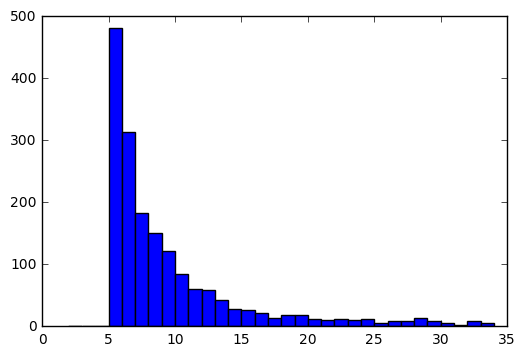

In [352]:
plt.hist(nBookCounts,range(2,35));
plt.xlim(0,35)

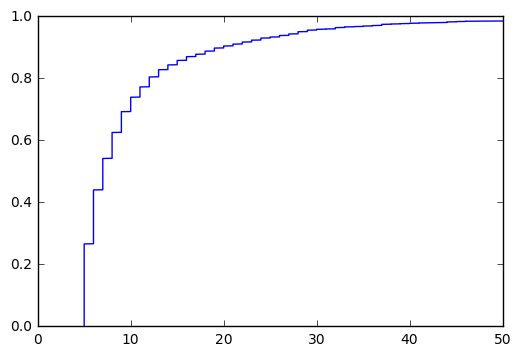

In [356]:
def get_cdf(a):
    sortedA = np.sort(a)
    yvals = np.arange(len(sortedA))/float(len(sortedA))
    return sortedA, yvals

sortedA, yvals = get_cdf(nBookCounts)
plt.plot(sortedA, yvals);
plt.xlim(0,50);
#plt.ylim(0.5,1);

In [357]:
glCommMeansTrain = glRatingsTrain.groupby(['comm'], {'meanRatingByComm': gl.aggregate.MEAN('rating')})
glCommMeansTrain

comm,meanRatingByComm
2,3.74623267028
3,3.83446272991
0,4.00854700855
6,4.08051529791
1,4.06194690265
4,3.55424528302
16,3.70967741935
15,3.7641025641
10,3.78947368421
18,3.79061685491


In [358]:
glCommBookMeansTrain = glRatingsTrain.groupby(['comm', 'bookID'], {'meanBookRatingByComm': gl.aggregate.MEAN('rating')})
glCommBookMeansTrain

bookID,comm,meanBookRatingByComm
19501,12,3.0
420282,2,5.0
216363,4,3.0
77013,12,3.33333333333
22328,3,5.0
77168,12,3.0
4953,23,3.5
64865,24,3.0
6149,2,5.0
17262203,4,3.0


In [359]:
commMeansTrain = {}
commBookMeansTrain = {}

for row in glCommMeansTrain:
    commMeansTrain[row['comm']] = row['meanRatingByComm']
    
for row in glCommBookMeansTrain:
    commBookMeansTrain[(row['bookID'], row['comm'])] = row['meanBookRatingByComm']

    
glRatingsTrainWithComm = glRatingsTrain.copy()
glRatingsTestWithComm = glRatingsTest.copy()

if 'comm' in glRatingsTrain.column_names():
    glRatingsTrain.remove_column('comm');
if 'comm' in glRatingsTest.column_names():
    glRatingsTest.remove_column('comm');

In [381]:
nTrainObs = glCommBookMeansTrain.shape[0]
nTrainUsers = len(glCommBookMeansTrain['comm'].unique())
nTrainItems = len(glCommBookMeansTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,6):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

12180 30 1800
6.65573770492
3.32786885246
2.21857923497
1.66393442623
1.33114754098


In [ ]:
#FACTORIZING COMM MEANS

In [382]:
commMeans_rec_engine_baseline = gl.factorization_recommender.create(
                                                    observation_data=glCommBookMeansTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='meanBookRatingByComm',
                                                    num_factors=4,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-12
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12180 observations with 30 users and 1800 items.

Data prepared in: 0.109099s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 12180 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 6.03122           | Not Viable                               |

| 1       | 1.50781           | 0.711133                                 |

| 2       | 0.753903          | Not Viable                               |

| 3       | 0.188476          | 0.739148                                 |

| 4       | 0.0942379         | 0.55651                                  |

| 5       | 0.0471189         | 0.569675                                 |

| 6       | 0.0235595         | 0.599688                                 |

| 7       | 0.0117797         | 0.647495                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0942379         | 0.55651                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 64us         | 0.798429          | 0.893548              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 659.481ms    | 0.822353          | 0.906832              | 0.0942379   |

| 2       | 1.29s        | 0.659511          | 0.812091              | 0.0438761   |

| 3       | 1.90s        | 0.620421          | 0.787625              | 0.0285948   |

| 4       | 2.54s        | 0.600833          | 0.775001              | 0.0203421   |

| 5       | 3.14s        | 0.593714          | 0.770187              | 0.0163028   |

| 6       | 3.79s        | 0.586349          | 0.764979              | 0.0136019   |

| 10      | 6.31s        | 0.572284          | 0.749686              | 0.00818068  |

| 11      | 6.94s        | 0.570074          | 0.745153              | 0.00743941  |

| 15      | 9.47s        | 0.559892          | 0.721699              | 0.00546033  |

| 20      | 12.64s       | 0.551572          | 0.694563              | 0.0040977   |

| 25      | 15.82s       | 0.546187          | 0.671718              | 0.00327934  |

| 30      | 18.95s       | 0.543017          | 0.652511              | 0.00273344  |

| 35      | 22.16s       | 0.54063           | 0.635598              | 0.00234335  |

| 40      | 25.35s       | 0.539475          | 0.621333              | 0.0020507   |

| 45      | 28.55s       | 0.53907           | 0.609623              | 0.00179487  |

| 50      | 31.73s       | 0.536624          | 0.59873               | 0.000996444 |

| 51      | 32.37s       | 0.535907          | 0.597234              | 0.000825554 |

| 55      | 34.89s       | 0.534751          | 0.593732              | 0.000463851 |

| 60      | 38.07s       | 0.533946          | 0.591432              | 0.000217274 |

| 65      | 41.26s       | 0.533672          | 0.590397              | 0.000121664 |

| 70      | 44.52s       | 0.533457          | 0.589827              | 5.75433e-05 |

| 75      | 47.74s       | 0.533359          | 0.589555              | 2.73207e-05 |

| 80      | 50.88s       | 0.533314          | 0.589423              | 1.30149e-05 |

| 85      | 54.02s       | 0.533297          | 0.589361              | 7.39471e-06 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 0.533285

Final training RMSE: 0.589344

In [250]:
#SIMPLE PREDICTION FROM COMM MEANS
def predictFromCommMeans(bookIDs, commIDs, commMeansTrain, commBookMeansTrain, useBookMeans):
    predictedRatings = []
    for bID, comm in zip(bookIDs, commIDs):
        if useBookMeans and ((bID, comm) in commBookMeansTrain):
            predictedRatings.append(commBookMeansTrain[(bID, comm)])
        else:
            predictedRatings.append(commMeansTrain[comm])
    return np.array(predictedRatings)

In [380]:
preds = predictFromCommMeans(glRatingsTestWithComm['bookID'], glRatingsTestWithComm['comm'], commMeansTrain, commBookMeansTrain, True)
sse = sum((np.array(preds) - glRatingsTest['rating'].to_numpy())**2)
rmse = np.sqrt(sse/len(preds))
print rmse

preds = rec_engine_8.predict(glRatingsTest)
sse = sum((np.array(preds) - glRatingsTest['rating'].to_numpy())**2)
rmse = np.sqrt(sse/len(preds))
print rmse

1.03126259896
0.893865789104


In [252]:
def mixedPred(glRatingsTestWithComm, commMeansTrain, commBookMeansTrain, rec_engine,\
              commMeans_rec_engine, socialRec, useBookMeans, meanWeight):
    if socialRec:
        preds = meanWeight*commMeans_rec_engine.predict(glRatingsTestWithComm['bookID', 'comm'])
    else:
        preds = meanWeight*predictFromCommMeans(\
                                              glRatingsTestWithComm['bookID'],
                                              glRatingsTestWithComm['comm'],
                                              commMeansTrain, commBookMeansTrain,
                                              useBookMeans
                                               )
    preds += (1-meanWeight)*rec_engine.predict(glRatingsTestWithComm['bookID', 'userID'])
    sse = sum((np.array(preds) - glRatingsTest['rating'].to_numpy())**2)
    rmse = np.sqrt(sse/len(preds))
    return preds, rmse

In [368]:
mixedPred(glRatingsTestWithComm, commMeansTrain, commBookMeansTrain, rec_engine_8,\
          commMeans_rec_engine_baseline, False, True, 1)[1]

1.0312625989644253

In [369]:
mixedPred(glRatingsTestWithComm, commMeansTrain, commBookMeansTrain, rec_engine_8,\
          commMeans_rec_engine_baseline, True, True, 1)[1]

0.93351886796558314

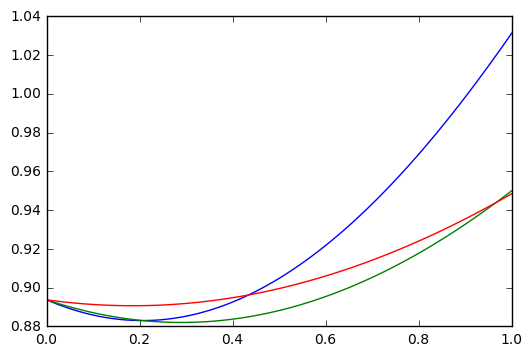

In [387]:
meanWeights = np.linspace(0,1,100)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, \
                          commMeans_rec_engine_baseline, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, \
                          commMeans_rec_engine_baseline, False, False, weight)[1])
    
#FACTORIZING COMM MEANS
rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, \
                          commMeans_rec_engine_baseline, True, True, weight)[1])

plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesFac, '-')

In [388]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

0.20202020202
0.883037218308

0.292929292929
0.882063448561


In [389]:
randCommIndices = {i: j for i, j in enumerate(np.random.permutation(len(allComms)))}

sanityCheck_commMeansTrain = {}
sanityCheck_commBookMeansTrain = {}

for row in glCommMeansTrain:
    sanityCheck_commMeansTrain[randCommIndices[row['comm']]] = row['meanRatingByComm']
    
for row in glCommBookMeansTrain:
    sanityCheck_commBookMeansTrain[(row['bookID'], randCommIndices[row['comm']])]\
                                   = row['meanBookRatingByComm']

In [390]:
#SIMPLE PREDICTION FROM COMM MEANS: sanity check
meanWeights = np.linspace(0,1,100)
rmsesSanityCheck = []
for weight in meanWeights:
    rmsesSanityCheck.append(\
                mixedPred(glRatingsTestWithComm, \
                          sanityCheck_commMeansTrain, sanityCheck_commBookMeansTrain,\
                          rec_engine_8, commMeans_rec_engine_baseline, False, True, weight)[1])

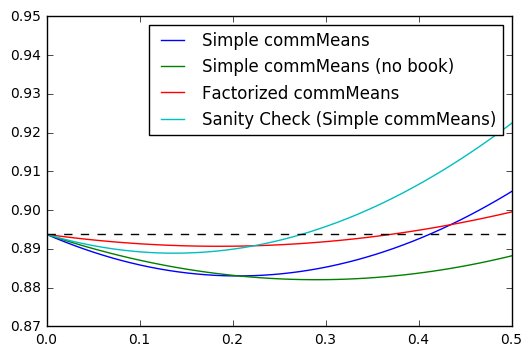

In [391]:
plt.plot(meanWeights, rmsesSimple, '-', label='Simple commMeans');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-', label='Simple commMeans (no book)');
plt.plot(meanWeights, rmsesFac, '-', label='Factorized commMeans')
plt.plot(meanWeights, rmsesSanityCheck, '-', label='Sanity Check (Simple commMeans)')
plt.legend()
plt.xlim(0, 0.5)
plt.ylim(0.87, 0.95)
plt.axhline(rmsesSimple[0],linestyle='--',color='k')

In [213]:
#cutoff date based

#glRatingDictTrain = makeRatingDictForGL(ratings, cutoffDate)
#glRatingsTrain = gl.SFrame(glRatingDictTrain)
#glRatingDictTest = makeRatingDictForGL(ratings, cutoffDate, upperBound=False)
#glRatingsTest = gl.SFrame(glRatingDictTest)

In [393]:

models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': [2, 4, 8],
                                                      'max_iterations': [200, 1000],
                                                      'regularization': [1e-2, 1e-3, 1e-4],
                                                      'linear_regularization': 1e-12
                                                      })

'''
models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 0,
                                                      'max_iterations': 200,
                                                      'regularization': 1e-3,
                                                      'linear_regularization': 
                                                      [10**i for i in range(-15,-4)]
                                                      })
'''

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-26-2016-00-55-0100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-26-2016-00-55-0100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Nov-26-2016-00-55-0100000' already exists. Renaming the job to 'Model-Parameter-Search-Nov-26-2016-00-55-0100000-38608'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-26-2016-00-55-0100000-38608' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-26-2016-00-55-0100000-38608' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-26-2016-00-55-0100001' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-26-2016-00-55

"\nmodels = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),\n                                                     gl.factorization_recommender.create,\n                                                     {'user_id': 'userID',\n                                                      'item_id': 'bookID',\n                                                      'target': 'rating',\n                                                      'num_factors': 0,\n                                                      'max_iterations': 200,\n                                                      'regularization': 1e-3,\n                                                      'linear_regularization': \n                                                      [10**i for i in range(-15,-4)]\n                                                      })\n"

In [394]:
models.get_status()
#models.get_results(wait=False).sort('validation_rmse')

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 18, 'Running': 0}

In [383]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-12
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 20473 observations with 367 users and 1800 items.

Data prepared in: 0.136898s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 20473 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.59255           | 0.673222                                 |

| 1       | 1.79628           | 0.663334                                 |

| 2       | 0.898138          | 0.647873                                 |

| 3       | 0.449069          | 0.629164                                 |

| 4       | 0.224534          | 0.605789                                 |

| 5       | 0.112267          | 0.609007                                 |

| 6       | 0.0561336         | 0.628044                                 |

| 7       | 0.0280668         | 0.65656                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.224534          | 0.605789                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 92us         | 0.934628          | 0.966762              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 661.841ms    | 1.24013           | 1.11361               | 0.224534    |

| 2       | 1.31s        | 0.835101          | 0.913838              | 0.0401177   |

| 3       | 1.94s        | 0.727887          | 0.853163              | 0.0220266   |

| 4       | 2.55s        | 0.703999          | 0.839047              | 0.0149891   |

| 5       | 3.18s        | 0.693943          | 0.833032              | 0.0114694   |

| 6       | 3.78s        | 0.68777           | 0.829319              | 0.00928839  |

| 10      | 6.28s        | 0.675957          | 0.822166              | 0.00527556  |

| 11      | 6.91s        | 0.674364          | 0.821196              | 0.00476131  |

| 15      | 9.37s        | 0.670459          | 0.818815              | 0.00342562  |

| 20      | 12.45s       | 0.667825          | 0.817206              | 0.00253625  |

| 25      | 15.56s       | 0.666175          | 0.816195              | 0.0020135   |

| 30      | 18.64s       | 0.665146          | 0.815565              | 0.00166941  |

| 35      | 21.75s       | 0.664348          | 0.815075              | 0.00142576  |

| 40      | 24.86s       | 0.663781          | 0.814727              | 0.00124418  |

| 45      | 28.00s       | 0.663332          | 0.814452              | 0.00110362  |

| 50      | 31.15s       | 0.662961          | 0.814224              | 0.000991598 |

| 51      | 31.76s       | 0.662893          | 0.814182              | 0.000971868 |

| 55      | 34.18s       | 0.662656          | 0.814037              | 0.000900221 |

| 60      | 37.32s       | 0.662416          | 0.813889              | 0.000824264 |

| 65      | 40.43s       | 0.662195          | 0.813754              | 0.000760128 |

| 70      | 43.57s       | 0.662015          | 0.813643              | 0.000705252 |

| 75      | 46.65s       | 0.661852          | 0.813543              | 0.000657766 |

| 80      | 49.68s       | 0.661714          | 0.813458              | 0.000616271 |

| 85      | 52.89s       | 0.661588          | 0.813381              | 0.000579701 |

| 90      | 56.00s       | 0.661478          | 0.813313              | 0.000547228 |

| 95      | 59.09s       | 0.661377          | 0.813251              | 0.0005182   |

| 100     | 1m 2s        | 0.661287          | 0.813195              | 0.000492096 |

| 101     | 1m 2s        | 0.661272          | 0.813186              | 0.000487188 |

| 105     | 1m 5s        | 0.661205          | 0.813145              | 0.000468496 |

| 110     | 1m 8s        | 0.661132          | 0.8131                | 0.000447057 |

| 115     | 1m 11s       | 0.66106           | 0.813056              | 0.000427493 |

| 120     | 1m 14s       | 0.660997          | 0.813017              | 0.00040957  |

| 125     | 1m 17s       | 0.660939          | 0.812982              | 0.00039309  |

| 130     | 1m 20s       | 0.660885          | 0.812948              | 0.000377884 |

| 135     | 1m 23s       | 0.660835          | 0.812917              | 0.000363811 |

| 140     | 1m 26s       | 0.660789          | 0.81289               | 0.000350749 |

| 145     | 1m 29s       | 0.660743          | 0.812861              | 0.000338592 |

| 150     | 1m 33s       | 0.660703          | 0.812837              | 0.000327249 |

| 155     | 1m 36s       | 0.660664          | 0.812812              | 0.000316642 |

| 160     | 1m 39s       | 0.660628          | 0.81279               | 0.000306701 |

| 165     | 1m 42s       | 0.660593          | 0.812769              | 0.000297365 |

| 170     | 1m 45s       | 0.660561          | 0.812749              | 0.000288581 |

| 175     | 1m 48s       | 0.660531          | 0.812731              | 0.000280301 |

| 180     | 1m 51s       | 0.660502          | 0.812712              | 0.000272482 |

| 185     | 1m 54s       | 0.660474          | 0.812695              | 0.000265088 |

| 190     | 1m 57s       | 0.660448          | 0.812679              | 0.000258085 |

| 195     | 2m 0s        | 0.660423          | 0.812664              | 0.000251442 |

| 200     | 2m 3s        | 0.660399          | 0.812649              | 0.000245133 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.659756

Final training RMSE: 0.812253

In [384]:
rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.8990755748218312

In [385]:
rec_engine_8 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=8,
                                                    solver='auto',
                                                    max_iterations=200,
                                                    regularization = 0.001,
                                                    linear_regularization = 1e-12
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 20473 observations with 367 users and 1800 items.

Data prepared in: 0.093508s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-12    |

| max_iterations                 | Maximum Number of Iterations                     | 200      |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 20473 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.59255           | 0.900368                                 |

| 1       | 1.79628           | Not Viable                               |

| 2       | 0.449069          | Not Viable                               |

| 3       | 0.112267          | 0.60851                                  |

| 4       | 0.0561336         | 0.627655                                 |

| 5       | 0.0280668         | 0.65667                                  |

| 6       | 0.0140334         | 0.706189                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.112267          | 0.60851                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 75us         | 0.934628          | 0.966762              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 704.056ms    | DIVERGED          | DIVERGED              | 0.112267    |

| RESET   | 748.65ms     | 0.9346            | 0.966747              |             |

| 1       | 1.36s        | 0.85435           | 0.92431               | 0.0561336   |

| 2       | 1.98s        | 0.745059          | 0.863168              | 0.0261181   |

| 3       | 2.59s        | 0.71512           | 0.845647              | 0.0170182   |

| 4       | 3.20s        | 0.700664          | 0.837056              | 0.0126209   |

| 5       | 3.82s        | 0.692989          | 0.832459              | 0.0100294   |

| 6       | 4.46s        | 0.688033          | 0.829477              | 0.00832088  |

| 9       | 6.31s        | 0.67939           | 0.824251              | 0.00550665  |

| 11      | 7.55s        | 0.676206          | 0.822317              | 0.00449348  |

| 14      | 9.42s        | 0.673237          | 0.820509              | 0.00352158  |

| 19      | 12.46s       | 0.670115          | 0.818604              | 0.00258847  |

| 24      | 15.58s       | 0.668264          | 0.817471              | 0.00204627  |

| 29      | 18.64s       | 0.667009          | 0.816703              | 0.00169188  |

| 34      | 21.69s       | 0.666109          | 0.81615               | 0.00144212  |

| 39      | 24.81s       | 0.665416          | 0.815724              | 0.00125662  |

| 44      | 27.87s       | 0.664886          | 0.815398              | 0.0011134   |

| 49      | 31.01s       | 0.664456          | 0.815133              | 0.000999482 |

| 51      | 32.25s       | 0.664295          | 0.815034              | 0.000960186 |

| 54      | 34.15s       | 0.664087          | 0.814905              | 0.000906714 |

| 59      | 37.22s       | 0.663788          | 0.81472               | 0.000829704 |

| 64      | 40.25s       | 0.663525          | 0.814557              | 0.000764752 |

| 69      | 42.78s       | 0.663306          | 0.814421              | 0.000709231 |

| 74      | 45.93s       | 0.66311           | 0.814298              | 0.000661225 |

| 79      | 49.06s       | 0.662936          | 0.814189              | 0.000619307 |

| 84      | 52.21s       | 0.662781          | 0.814092              | 0.000582386 |

| 89      | 55.29s       | 0.662636          | 0.814                 | 0.00054962  |

| 94      | 58.40s       | 0.662519          | 0.813926              | 0.000520345 |

| 99      | 1m 1s        | 0.662406          | 0.813855              | 0.00049403  |

| 101     | 1m 2s        | 0.662362          | 0.813827              | 0.000484235 |

| 104     | 1m 4s        | 0.6623            | 0.813787              | 0.000470249 |

| 109     | 1m 7s        | 0.662208          | 0.813728              | 0.000448652 |

| 114     | 1m 10s       | 0.662121          | 0.813671              | 0.000428952 |

| 119     | 1m 13s       | 0.66204           | 0.813619              | 0.000410909 |

| 124     | 1m 16s       | 0.661966          | 0.813571              | 0.000394323 |

| 129     | 1m 19s       | 0.661896          | 0.813524              | 0.000379024 |

| 134     | 1m 22s       | 0.661833          | 0.813482              | 0.000364867 |

| 139     | 1m 25s       | 0.661771          | 0.813441              | 0.00035173  |

| 144     | 1m 28s       | 0.661716          | 0.813404              | 0.000339506 |

| 149     | 1m 31s       | 0.661664          | 0.813369              | 0.000328104 |

| 154     | 1m 34s       | 0.661613          | 0.813334              | 0.000317442 |

| 159     | 1m 37s       | 0.661566          | 0.813302              | 0.000307451 |

| 164     | 1m 40s       | 0.661521          | 0.813271              | 0.00029807  |

| 169     | 1m 43s       | 0.661478          | 0.813241              | 0.000289245 |

| 174     | 1m 46s       | 0.66144           | 0.813213              | 0.000280927 |

| 179     | 1m 49s       | 0.661402          | 0.813186              | 0.000273074 |

| 184     | 1m 52s       | 0.661366          | 0.81316               | 0.000265648 |

| 189     | 1m 55s       | 0.661331          | 0.813135              | 0.000258616 |

| 194     | 1m 57s       | 0.661299          | 0.813111              | 0.000251946 |

| 199     | 2m 0s        | 0.661268          | 0.813088              | 0.000245612 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.660619

Final training RMSE: 0.812688

In [386]:
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.893759935074
-0.00531563974822


In [ ]:
0.880022805682
-0.00584060243154

In [1224]:
friendCounts = []
userIDlist = []

for f in friends.find():
    userIDlist.append(f['userID'])
    
userIDset = set(userIDlist)

for f in friends.find():
    friendCounts.append(len(set(f['friends']) & userIDset))

In [1225]:
friendCounts = pd.Series(friendCounts)
friendCounts.describe()

count    926.00000
mean       4.11987
std        9.86458
min        0.00000
25%        0.00000
50%        1.00000
75%        2.00000
max       66.00000
dtype: float64

In [1226]:
(friendCounts > 0).sum()

471

In [1227]:
adj_dict = {}
for f in friends.find():
    curFlist = set(f['friends'])
    friendsInData = curFlist & set(userIDlist)
    if len(friendsInData) > 0:
        adj_dict[f['userID']] = list(friendsInData)

In [1228]:
len(adj_dict)

471

In [1229]:
g = nx.from_dict_of_lists(adj_dict)

In [1230]:
#nx.draw(g, node_size=10, alpha=0.25)

In [1231]:
commDict = community.best_partition(g)
#colorDict = {k: min(v+1,11) + int(v>11) for k, v in commDict.items()}
colorNames = colors.cnames.keys()
colorDict = {k: colorNames[v % len(colorNames)] for k, v  in commDict.items()}
max(commDict.values())

68

In [1276]:
g.graph['overlap']='True'
#g.graph['size'] = '16, 9'
#g.graph['ratio'] = 0

nx.set_node_attributes(g, 'color', colorDict)
nx.set_node_attributes(g, 'colorscheme', 'svg')
nx.set_node_attributes(g, 'style', 'filled')

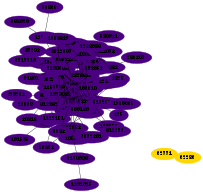

In [1277]:
nxpd.draw(g.subgraph(filter(lambda node: commDict[node] < 2, g.nodes())), \
          layout='neato', show='ipynb')

In [1282]:
communityNodes = [nodes for nodes in nx.connected_components(g)]
#communityNodes = \
#[[uID for uID in commDict if commDict[uID] == i] for i in range(max(commDict.values()))]

In [1283]:
communitySizes = [len(nodes) for nodes in communityNodes]

In [1284]:
commsOfInterest = [(i, communitySizes[i]) for i in range(len(communitySizes))\
                   if communitySizes[i] > 2 and communitySizes[i] < 30]
commsOfInterest

[(3, 3),
 (4, 3),
 (5, 3),
 (7, 3),
 (8, 3),
 (10, 5),
 (12, 3),
 (16, 3),
 (19, 4),
 (20, 6),
 (24, 3),
 (28, 3),
 (30, 3),
 (31, 3),
 (43, 4),
 (45, 3),
 (48, 3)]

0
{}

1
{}

2
{}

3
{}

4
{}

5
{147144: 1.0, 146673: 1.0, 147162: 1.0, 147284: 1.0, 146629: 1.0}

6
{}

7
{}

8
{}

9
{135817: 1.0, 134021: 1.0, 52823: 1.0}

10
{94664: 1.0, 94819: 1.0, 105159: 1.0}

11
{}

12
{}

13
{}

14
{58672: 1.0, 56276: 1.0, 56692: 1.0, 56493: 1.0}

15
{}

16
{}



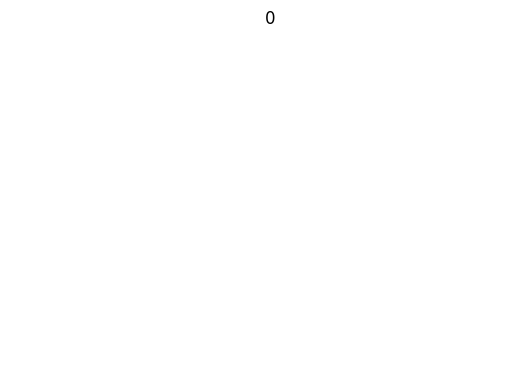

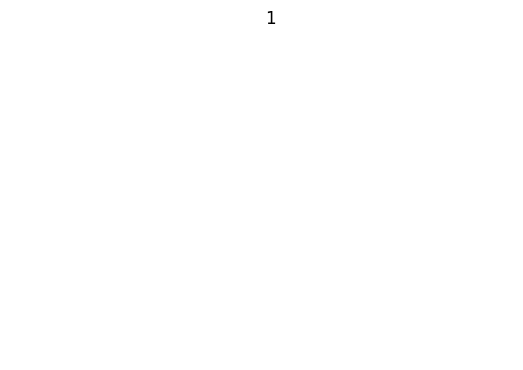

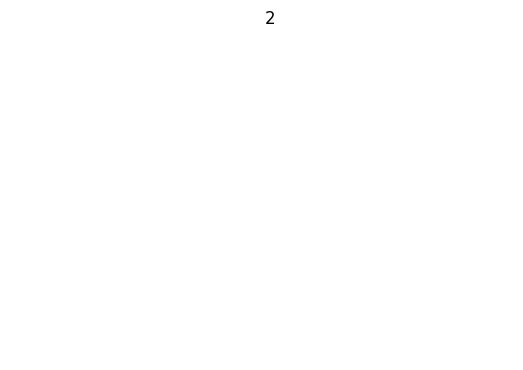

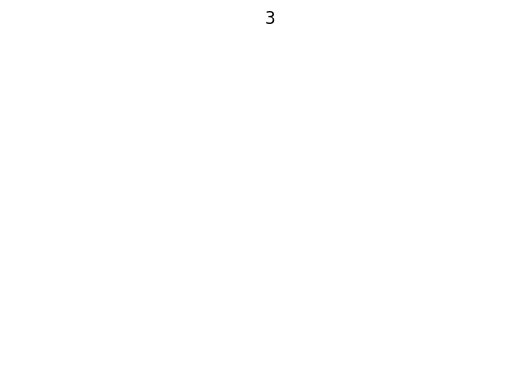

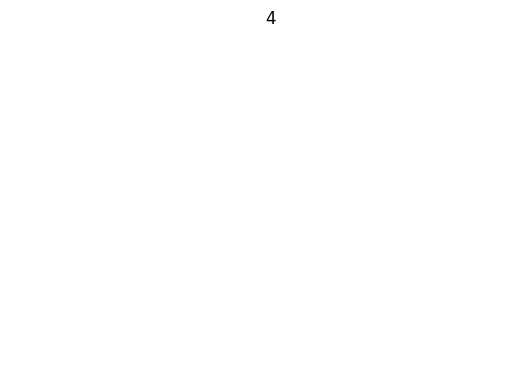

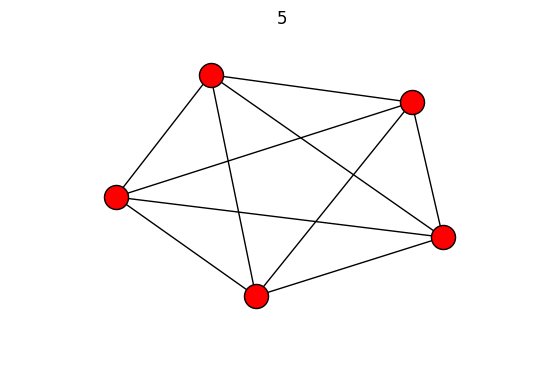

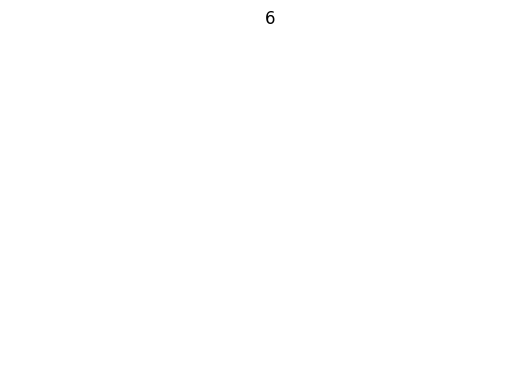

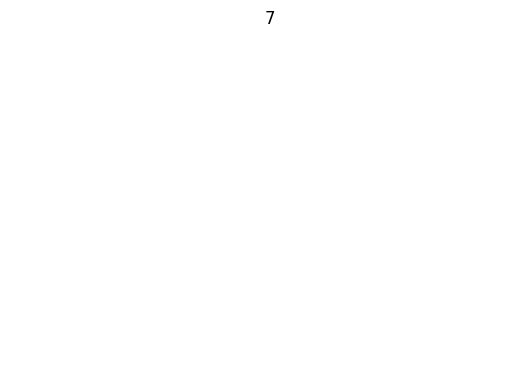

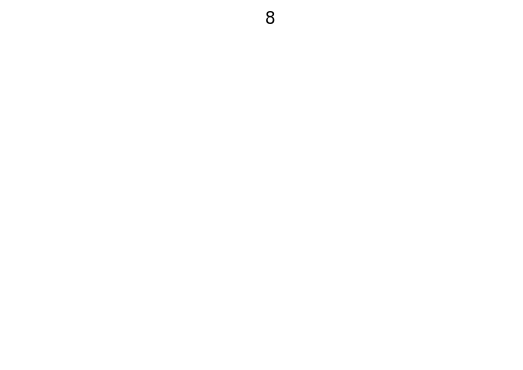

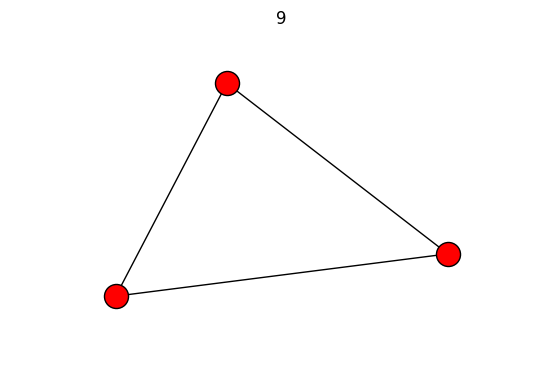

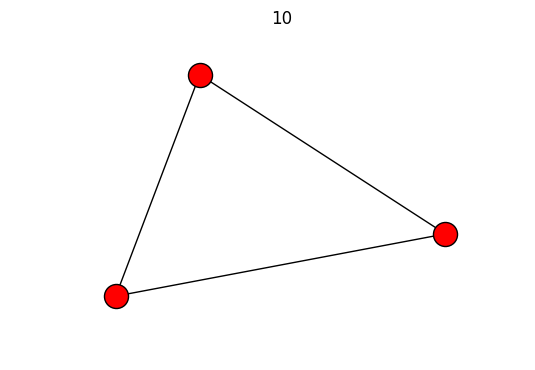

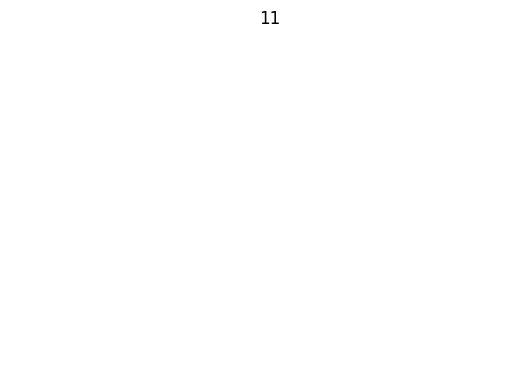

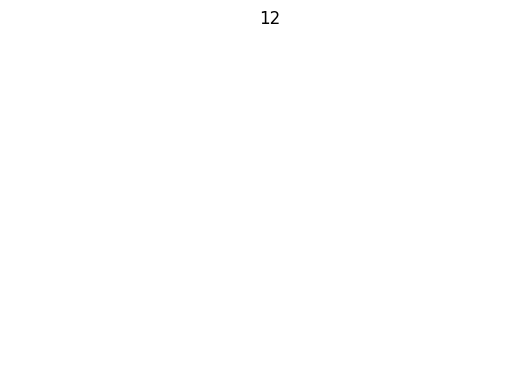

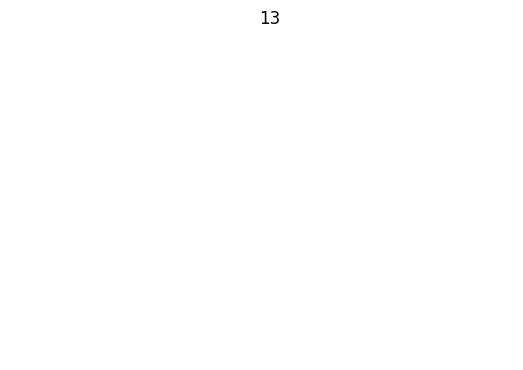

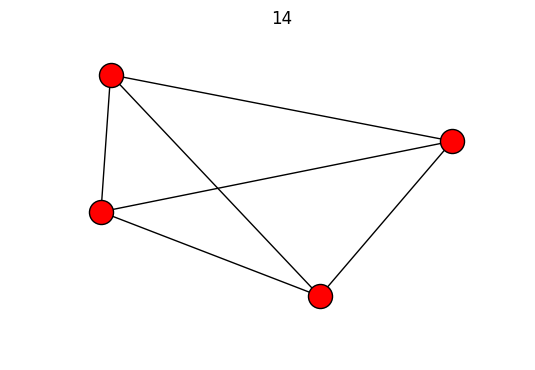

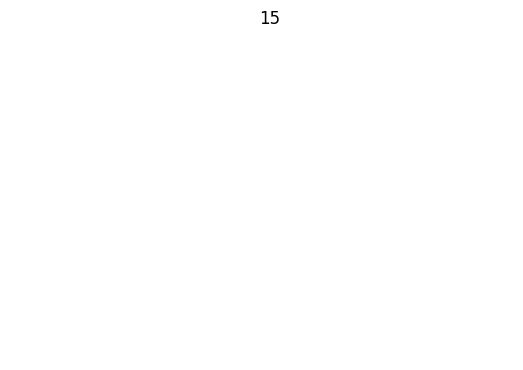

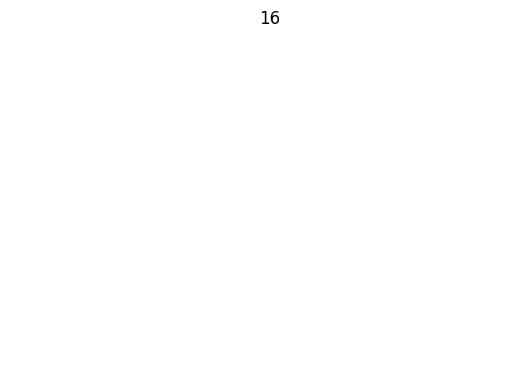

In [1297]:
reducedCommsOfInterest = []
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sgClustering = nx.clustering(sg)
    reducedComm = [node for node in communityNodes[commIndex[0]]\
                  if sgClustering[node] > 0]
    if True:#len(reducedComm) > 0 and nx.number_connected_components(sg.subgraph(reducedComm)) == 1:
        reducedCommsOfInterest.append(reducedComm)


for i, comm in enumerate(reducedCommsOfInterest):
    sg = g.subgraph(comm)
    plt.figure()
    print str(i) + '\n' + str(nx.clustering(sg)) + '\n'
    plt.title(i)
    nx.draw(sg, pos=nx.fruchterman_reingold_layout(sg, k=1))

In [414]:
'''
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sg.graph['overlap'] = 'scale'
    plt.figure()
    plt.title(str(i) + '\n' + str(nx.average_clustering(sg)))
    nx.draw(sg, labels = nx.clustering(sg), pos=nx.fruchterman_reingold_layout(sg))
'''

"\nfor i, commIndex in enumerate(commsOfInterest):\n    sg = g.subgraph(communityNodes[commIndex[0]])\n    sg.graph['overlap'] = 'scale'\n    plt.figure()\n    plt.title(str(i) + '\n' + str(nx.average_clustering(sg)))\n    nx.draw(sg, labels = nx.clustering(sg), pos=nx.fruchterman_reingold_layout(sg))\n"

In [1298]:
completedCommsOfInterest = []
for comm in reducedCommsOfInterest:
    commFriendsLevel1 = {f['userID']: f['friends'] \
                         for f in friends.find({'userID': {'$in': comm}})\
                        }
    graphCommFriendsLevel1 = nx.from_dict_of_lists(commFriendsLevel1)
    
    completedCommsOfInterest.append([node for node in graphCommFriendsLevel1.nodes() \
     if nx.clustering(graphCommFriendsLevel1)[node] > 0])

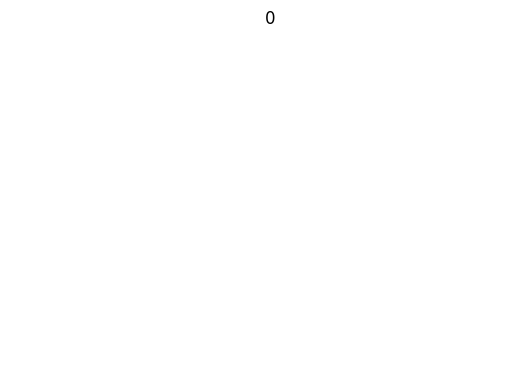

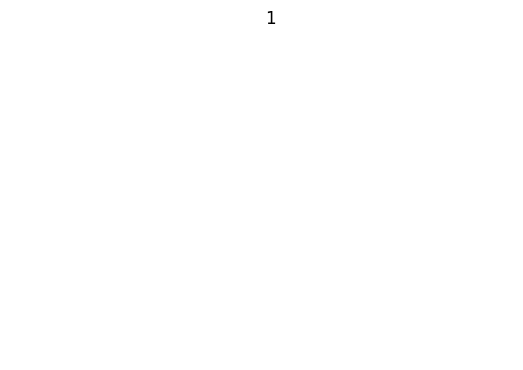

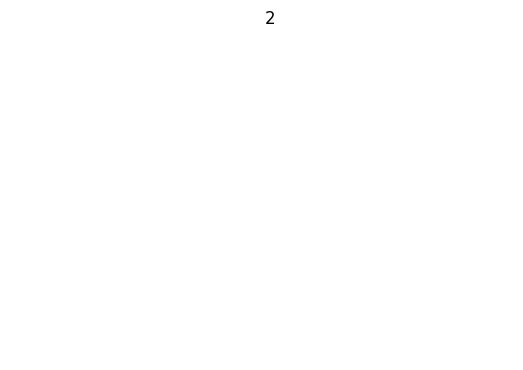

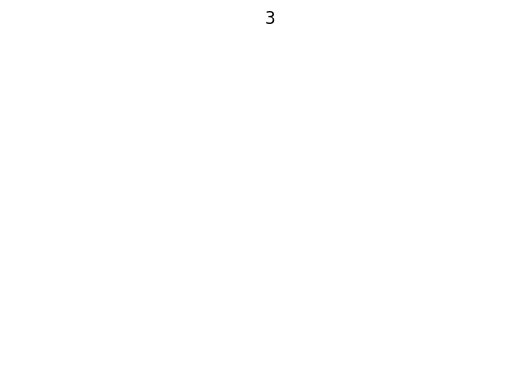

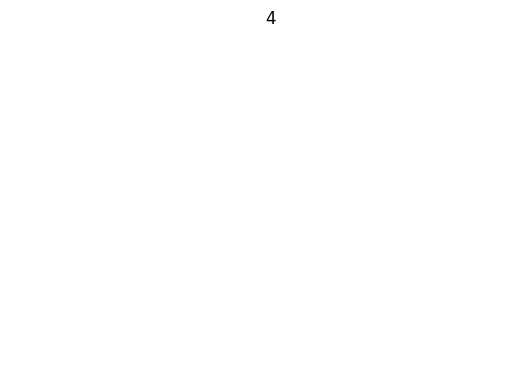

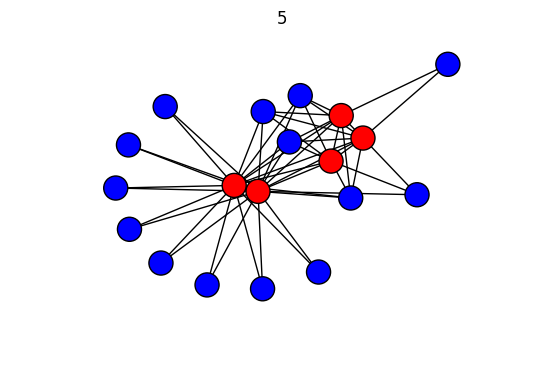

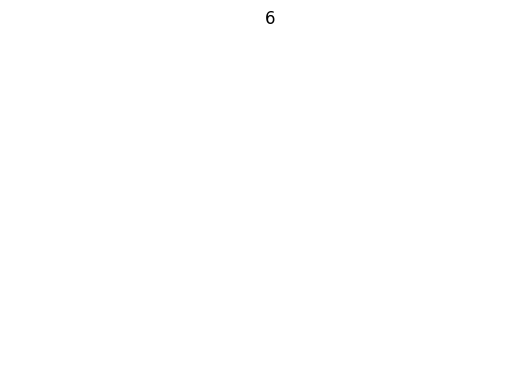

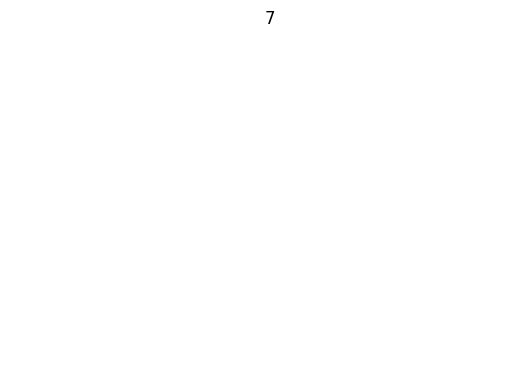

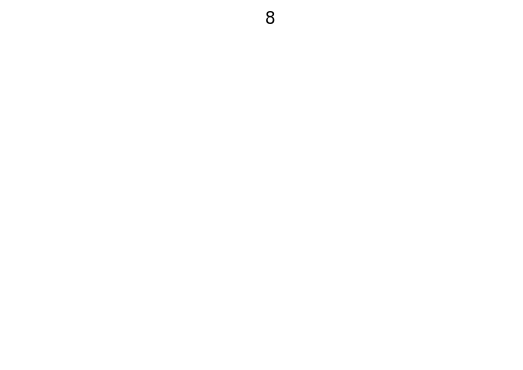

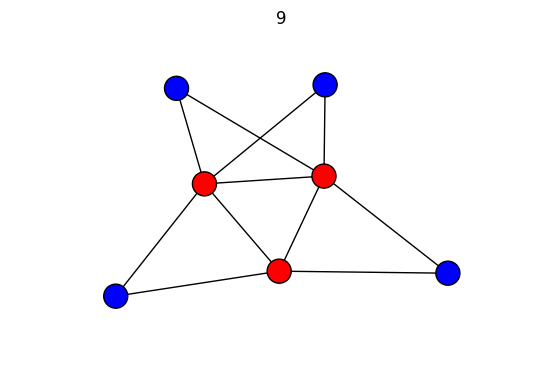

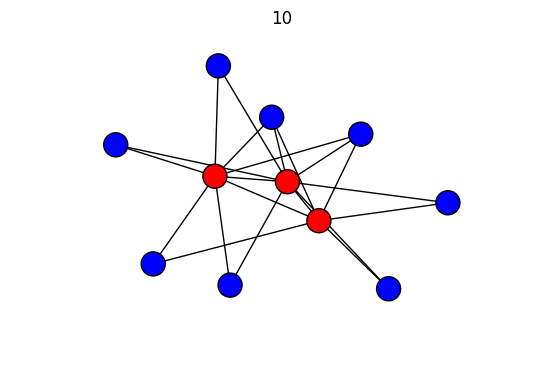

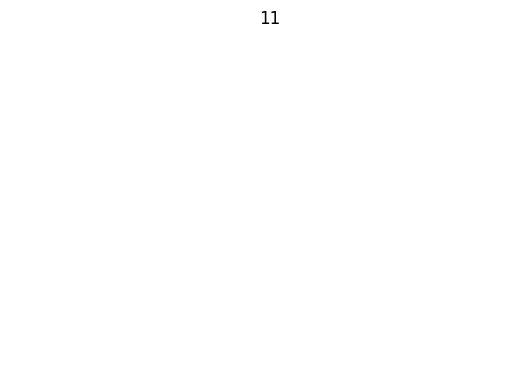

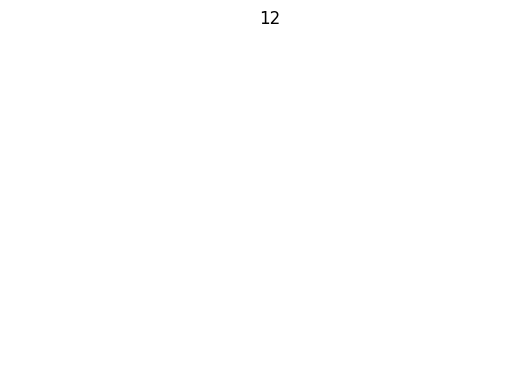

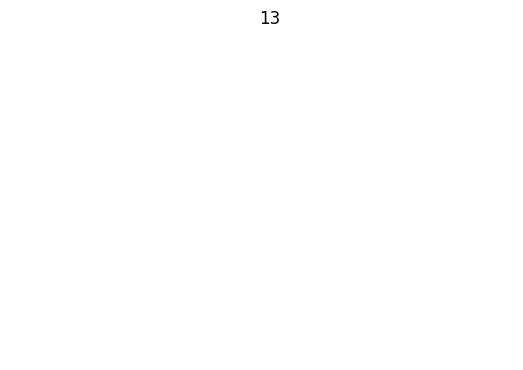

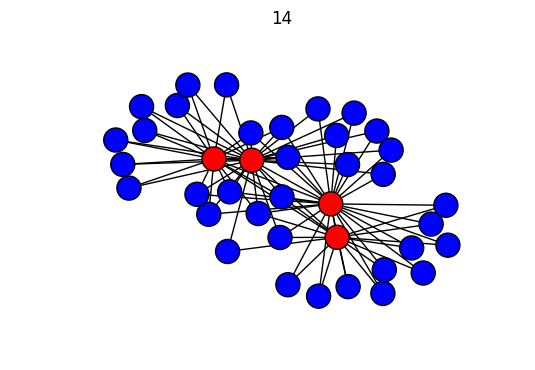

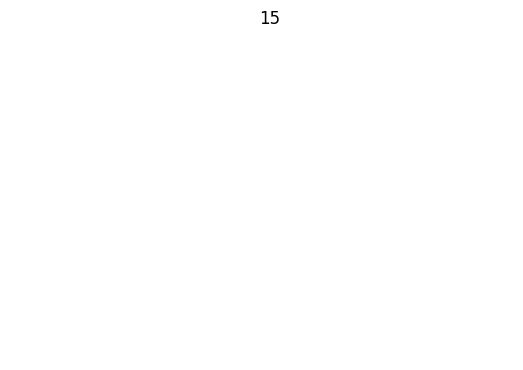

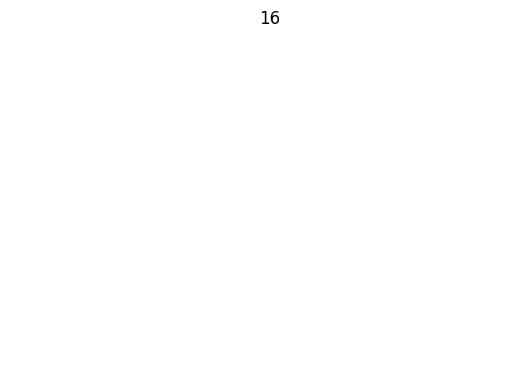

In [1299]:
for i, (comm1, comm2) in enumerate(zip(reducedCommsOfInterest, completedCommsOfInterest)):
    commFriendsLevel1 = {f['userID']: f['friends'] \
                         for f in friends.find({'userID': {'$in': comm1}})\
                        }
    graphCommFriendsLevel1 = nx.from_dict_of_lists(commFriendsLevel1)
    sg = graphCommFriendsLevel1.subgraph(comm2)
    colorDict = {True: 'r', False: 'b'}
    
    plt.figure()
    plt.title(i)
    nx.draw(sg, pos=nx.fruchterman_reingold_layout(sg), \
            node_color = [colorDict[node in comm1] for node in sg.nodes()]\
           )

In [762]:
dbFromBook['comms'].delete_many({});
dbFromBook['comms'].insert_one({'comms': completedCommsOfInterest});

In [920]:
dbFromBook.collection_names()

[u'adj_dict',
 u'books',
 u'commBooks',
 u'commFriends',
 u'commRatings',
 u'comms',
 u'friends',
 u'reviews',
 u'system.indexes']

In [764]:
books = dbFromBook['commBooks']
ratings = dbFromBook['commRatings']
friends = dbFromBook['commFriends']

print books.count()
print ratings.count()
print sum([len(comm) for comm in completedCommsOfInterest])

6326
65
280


In [571]:
commRatingMeans = []
for commIndex in completedCommsOfInterest:
    commRatings = []
    for r in ratings.find({'userID': {'$in': commIndex}}):
        if str(focalBookID) in r['ratings']:
            commRatings.append(r['ratings'][str(focalBookID)][0])
    commRatingMeans.append(np.mean(commRatings))

In [869]:
commSets = [set(comm) for comm in completedCommsOfInterest]

for j, b in enumerate(dbFull['books'].find()):
    bookID = b['bookID']
    ratingSet = set([int(k) for k in b['ratings'].keys()])
    commsOfRaters = [i for i, comm in enumerate(commSets)\
                    if len(comm & ratingSet) > 0]
    dbFull['books'].update_one(
            {"bookID": bookID},
            {"$set": {'commsOfRaters': commsOfRaters}},
            upsert=True)
    if j % 1000 == 0:
        print float(j) / dbFull['books'].count()

0.0
0.0147338333014
0.0294676666028
0.0442014999042
0.0589353332056
0.0736691665071
0.0884029998085
0.10313683311
0.117870666411
0.132604499713
0.147338333014
0.162072166316
0.176805999617
0.191539832918
0.20627366622
0.221007499521
0.235741332823
0.250475166124
0.265208999425
0.279942832727
0.294676666028
0.30941049933
0.324144332631
0.338878165932
0.353611999234
0.368345832535
0.383079665837
0.397813499138
0.412547332439
0.427281165741
0.442014999042
0.456748832344
0.471482665645
0.486216498947
0.500950332248
0.515684165549
0.530417998851
0.545151832152
0.559885665454
0.574619498755
0.589353332056
0.604087165358
0.618820998659
0.633554831961
0.648288665262
0.663022498563
0.677756331865
0.692490165166
0.707223998468
0.721957831769
0.736691665071
0.751425498372
0.766159331673
0.780893164975
0.795626998276
0.810360831578
0.825094664879
0.83982849818
0.854562331482
0.869296164783
0.884029998085
0.898763831386
0.913497664687
0.928231497989
0.94296533129
0.957699164592
0.972432997893
0.987

In [910]:
booksToExclude = set()
booksToInclude = set()

for b in books.find():
    if len(b['commsOfRaters']) < 2 or len(b['ratings']) < 10:
        booksToExclude.add(b['bookID'])
    else:
        booksToInclude.add(b['bookID'])

In [911]:
print len(booksToExclude)
print len(booksToInclude)
print ratings.count()

67318
553
355


In [912]:
nUserCounts = []
for i, row in enumerate(ratings.find()):
    nUserCounts.append(len(row['ratings']))
    
nBookCounts = []
bookIDlist = []
for i, row in enumerate(books.find({'bookID': {'$in': list(booksToInclude)}})):
    nBookCounts.append(len(row['ratings']))
    bookIDlist.append(row['bookID'])

In [913]:
nUserCounts = pd.Series(nUserCounts)
nBookCounts = pd.Series(nBookCounts)

print nBookCounts.describe()

count    553.000000
mean      20.106691
std       14.703883
min       10.000000
25%       11.000000
50%       15.000000
75%       23.000000
max      119.000000
dtype: float64


In [915]:
glRatingDict = makeRatingDictForGL(ratings, booksToExclude)
glRatings = gl.SFrame(glRatingDict)

In [916]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID")

In [917]:
nTrainObs = glRatingsTrain.shape[0]
nTrainUsers = len(glRatingsTrain['userID'].unique())
nTrainItems = len(glRatingsTrain['bookID'].unique())

print nTrainObs, nTrainUsers, nTrainItems

for n in range(1,9):
    print nTrainObs / (n*float(nTrainUsers + nTrainItems))

14630 331 553
16.5497737557
8.27488687783
5.51659125189
4.13744343891
3.30995475113
2.75829562594
2.36425339367
2.06872171946


In [918]:
for i in range(len(completedCommsOfInterest)):
    commratings = \
    np.array([row['rating'] for row in glRatingsTrain if row['userID'] in completedCommsOfInterest[i]])
    print (i, len(completedCommsOfInterest[i]), len(commratings))

(0, 12, 504)
(1, 13, 703)
(2, 12, 210)
(3, 40, 829)
(4, 4, 121)
(5, 10, 334)
(6, 17, 599)
(7, 17, 680)
(8, 7, 208)
(9, 15, 246)
(10, 13, 619)
(11, 4, 93)
(12, 22, 588)
(13, 17, 490)
(14, 6, 151)
(15, 16, 894)
(16, 24, 655)
(17, 12, 321)
(18, 19, 690)


In [789]:
clientJest = MongoClient("mongodb://35.163.255.3")
dbJest = clientJest['goodreads_explore_from_book_jest']

clientUlysses = MongoClient("mongodb://35.161.242.150")
dbUlysses = clientUlysses['goodreads_explore_from_book_ulysses']

clientAtlas = MongoClient("mongodb://35.161.154.87")
dbAtlas = clientAtlas['goodreads_explore_from_book_atlas']

clientManifesto = MongoClient("mongodb://35.160.173.218")
dbManifesto = clientManifesto['goodreads_explore_from_book_manifesto']

dbList = [dbJest, dbUlysses, dbAtlas, dbManifesto]

71038


In [828]:
books.find_one({'bookID': int(ratings.find_one()['ratings'].keys()[0])})

{u'_id': ObjectId('5833403cae0a79b494b90c49'),
 u'bookID': 18194,
 u'commsOfRaters': [0],
 u'ratings': {u'146050': [0, u'Jan 2003', u'Jun 22, 2007'],
  u'147144': [3, u'not set', u'Jun 22, 2007']}}

In [830]:
#friendsFull.insert_many(dbJest['friends'].find())
#friendsFull.insert_many(dbUlysses['friends'].find())
#friendsFull.insert_many(dbAtlas['friends'].find())
#friendsFull.insert_many(dbManifesto['friends'].find())

for db in dbList:
    for i, r in enumerate(db['commRatings'].find()):
        if ratings.find({'userID': r['userID']}).count() == 0:
            ratings.insert_one(r)
        for bookID in r['ratings'].keys():
            if books.find({'bookID': int(bookID)}).count() == 0:
                b = db['commBooks'].find_one({'bookID': int(bookID)})
                if b is not None:
                    books.insert_one(b)
        if i % 10 == 0:
            print i
    '''
    for b in db['commBooks'].find():
        if books.find({'bookID': b['bookID']}).count() == 0:
            books.insert_one(b)
        if books.count() % 1000 == 0:
            print float(books.count()) / sum([db['commBooks'].count() for db in dbList])
    '''

0
10
20
30
40
50
60
0
10
20
0
10
20
30
0
10
20
30


In [833]:
dbFull['comms'].delete_many({});
dbFull['comms'].insert_one({'comms': completedCommsOfInterest});

In [941]:
client.database_names()

[u'goodreads_explore_from_book_tnc',
 u'goodreads_explore_multigraph_biased_sampling',
 u'goodreads_explore',
 u'goodreads_full',
 u'goodreads_explore_from_book_hedgehog',
 u'goodreads_explore_from_book_mice_and_men',
 u'local',
 u'goodreads_explore_from_book_jest',
 u'goodreads_explore_from_book_swiftly',
 u'goodreads_explore_from_book',
 u'goodreads_explore_from_book_lies',
 u'goodreads',
 u'goodreads_explore_from_book_divergent',
 u'goodreads_explore_multigraph']

In [90]:
rec_engine_8 = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=8,
                                                    solver='auto',
                                                    max_iterations=1000,                                                  max_iterations=1000,
                                                    regularization = 1e-12,
                                                    linear_regularization = 1
                                                    )

SyntaxError: keyword argument repeated (<ipython-input-90-2a5669fd64c7>, line 7)

In [ ]:
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
print rec_engine_8.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

In [33]:
rec_engine = rec_engine_8

bookWeightings = rec_engine.get('coefficients')['bookID']
npBookWeightings = bookWeightings['factors'].to_numpy()
for i, row in enumerate(npBookWeightings):
    npBookWeightings[i,:] /= np.linalg.norm(row)
bookWeightings['factors'] = gl.SArray(npBookWeightings)
bookWeightings = bookWeightings.unpack('factors')

In [52]:
bookWeightings.sort('factors.0', ascending=False)['factors.0'][50]

0.9777261449253141

In [55]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.0', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Flow My Tears, the Policeman Said
The Left Hand of Darkness
      
          (Hainish Cycle #6)
On Beauty
Dance Dance Dance
      
          (The Rat #4)
The Mote in God's Eye
      
          (Moties #1)
Labyrinths:  Selected Stories and Other Writings
------
Swann's Way
      
          (À la recherche du temps perdu #1)
Exodus


In [59]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.1', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

The Taming of the Shrew
Mansfield Park
The Power and the Glory
------
To Say Nothing of the Dog
      
          (Oxford Time Travel #2)
A History of the World in 10½  Chapters


In [61]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.2', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 10])

Waiting
The War of the Worlds
The Sandman, Vol. 2: The Doll's House
      
          (The Sandman #2)
------



In [57]:
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])
print '------'
print '\n'.join([bookTitle(int(bID)) 
                 for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:100]
                 if len(books.find_one({'bookID': int(bID)})['ratings']) > 20])

Player Piano
The Snows of Kilimanjaro and Other Stories
------
The Time Traveler's Wife
The Silence of the Lambs
      
          (Hannibal Lecter #2)
Foundation's Edge
      
          (Foundation (Publication Order) #4)


In [58]:
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=False)['bookID'][:5]])
print '------'
print '\n'.join([bookTitle(int(bID)) for bID in bookWeightings.sort('factors.3', ascending=True)['bookID'][:5]])

Casino Moon
Out on the Rim
      
          (Arthur Case Wu #2)
Outsider in Amsterdam
      
          (Amsterdam Cops Mysteries #1)
Dark Canyon
What's Not to Love?: The Adventures of a Mildly Perverted Young Writer
------
Hidden History: Exploring Our Secret Past
Among the Believers : An Islamic Journey
The Bottoms
American Scream
Fenwick Travers and the Years of Empire: An Entertainment


In [21]:
dfBookWeightings = bookWeightings.to_dataframe()

In [22]:
dfBookWeightings[dfBookWeightings['bookID']==str(focalBookID)]

,bookID,linear_terms,factors.0,factors.1,factors.2,factors.3
11,118154,0.154152,0.347579,0.171606,0.851917,0.352106


In [23]:
userWeightings = rec_engine.get('coefficients')['userID'].unpack('factors')

In [24]:
dfUserWeightings = userWeightings.to_dataframe()

In [62]:
dfUserWeightings[dfUserWeightings['userID']==7607437] #N.R.

,userID,linear_terms,factors.0,factors.1,factors.2,factors.3
7,7607437,0.759385,0.278522,-0.682661,0.481648,0.093921


In [235]:
targetTruth = glRatingsTest[glRatingsTest['bookID'] == str(focalBookID)]

(15, 3)

In [61]:
targetPreds = barthTruth['userID','rating'].add_column(rec_engine.predict(targetTruth), name="modelRating")

NameError: name 'rec_engine' is not defined

In [366]:
evalTarget = rec_engine.evaluate_rmse(targetTruth, target='rating')
print evalTarget['rmse_overall']
print evalTarget['rmse_overall'] - eval['rmse_overall']

0.888040534664
-0.0348179848496


In [11]:
allFriendIDs = reduce(lambda l1, l2: l1+l2, [f['friends'] for f in friends.find()])

In [12]:
len(allFriendIDs) - len(set(allFriendIDs))

7651

In [17]:
df = pd.DataFrame([userIDlist, list(friendCounts)]).T
friendLocs = df.iloc[:,0][df.iloc[:,1]>0]

In [18]:
fullTargetTruth = glRatings[glRatings['bookID'] == str(focalBookID)]
fullTargetTruthDf = fullTargetTruth.to_dataframe()
fullTargetTruthDf.set_index('userID',inplace=True)
fullTargetTruthDf['rating'].describe()

NameError: name 'glRatings' is not defined

In [19]:
fullTargetTruthDf.loc[friendLocs,:]

NameError: name 'fullTargetTruthDf' is not defined